## 运行环境
python 3.6.3

Anaconda custom (64-bit)

win10

In [1]:
import numpy as np # 矩阵运算
import matplotlib.pyplot as plt # 绘图
from PIL import Image # 显示图片
# from functools import reduce

## 任务定义

Character recognition (digits) data

26个手写英文字符识别

使用全连接的神经网络

加入正则化, dropout, 并且使用random mini batch 加快训练速度

--------------------------

## 输入数据定义trainX, trainY, testY, testX

### 预处理数据

处理后,
```python
trainX.shape = (128, 47010) # fold 0~8
trainY.shape = (26, 47010)  # fold 0~8
testY.shape = (26, 5142)    # fold 9
testX.shape = (128, 5142)   # fold 9
```

#### 数据含义

如英文名, train代表训练集, test代表测试集, X代表图片数据, Y代表图片标签
```python
trainX[:,i]会得到shape = (128,) 的一列数据, 代表一张图片
testY[:,i]会得到shape = (26,) 的一列数据, 代表一个标签
```


## 载入训练需要的数据

### 辅助函数

In [2]:
# 对于每行数据, 定义一个函数来处理
# parameters : row -- 一行手写体数据
# return : 返回2个参数, 
# attribute -- 手写体的属性
# tuple(imageData) -- bool数组的图片, size为128

def getImageArray(row):
    assert(type(row)==str),'parameter is not a string'
    row = row.split() # split by tab, i.e '\t'
    attribute = row[:6] # before image
    imageData = row[6:] # image
    imageData = map(lambda c:c == '1',imageData) # get the bool data
    return attribute,tuple(imageData) # list of str , tuple of bool

# char -> tuple of bool
def char2label(char):
    letters = range(26)
    letters = map(lambda num:chr(ord('a')+num),letters) # map [0,25] -> ['a','z']
    letters = map(lambda c:c==char,letters) # ['a','z'] -> [bool]
    return tuple(letters)

# tuple of bool -> Image object
def bool2image(boolArray):
    assert(len(boolArray) == 128),'length is not 128 is'+str(len(boolArray))
    ans = tuple(map(lambda x:255 if x else 0,boolArray)) # (bool.) -> (int,)
    ans = np.array(ans) # (int,) -> numpy.array object
    assert(ans.shape == (128,)),'shape is wrong, it\'s not' + str(ans.shape)
    ans = ans.reshape(16,8) # reshape to correct size
    return Image.fromarray(ans) # 使用plt.imshow(im) 直接从array中显示图像

'''
tuple -> numpy.array
suppose there are n elements in tuple,
and every element have same size m,
then return a array with shape(m,n),
i.e every element map to a column of numpy.array
'''
def tuples2array(t):
    assert(type(t) == tuple),'parameter is not a tuple'
    n = len(t) # n elements in t
    m = len(t[0]) # any element in t have size m
    # if length of arr is m, the get a array of shape (m,1)
    toColumnArray = lambda element:np.array(element,dtype = np.float16).reshape(m,1) # watch out here, the type of data
    arrays = tuple(map(toColumnArray,t))
    matrix = np.concatenate(arrays,axis = 1) # matrix[i] = t[i] now
    # axis = 1 mean add n column to be a matrix
    assert(matrix.shape == (m,n)),'matrix\' shape is wrong'
    return matrix

# ((bool),(bool)) -> (narray,narray)
def fold2set(fold):
    labelArray = tuple(map(lambda t:t[0],fold)) # ((bool),(bool)) -> ((bool)), take first
    labelArray = tuples2array(labelArray) # ((bool)) -> narray
    imageArray = tuple(map(lambda t:t[1],fold)) # ((bool),(bool)) -> ((bool)), take second
    imageArray = tuples2array(imageArray) # ((bool)) -> narray
    return labelArray,imageArray

### 对数据进行预处理
将每行的代表的手写体字母, 变为2个bool元组, label和imageData

并根据fold对数据进行分类

`dataFold[i]` 代表fold为i的数据集, 数据类型为list,list里边每个element的数据类型为(label,imageData)

* label 为tuple, 长度为26, element的数据类型为bool, 且仅有1个element的值为True, 其余的为False

* imageData 为tuple, 长度为128, element的数据类型为bool, 可代表一张letter图片

In [3]:
data = None # 存所有数据的变量
with open('letter.data') as f:
    data = f.readlines() # 一次读入所有行
# data 中的每一行对应一个手写体字母

dataFold = list(map(lambda x:[],range(10))) # 根据flod来放置数据, 有10个空列表[], 
# 即dataFold = [[], [], [], [], [], [], [], [], [], []]

# dataFold[i] 表示 1个存了多张图片的list
# 每个数据为1个二元组, 即 (label,imageData) -- label 表示字母标识tuple 26, imageData代表图像像素值,tuple 128
for row in data:
    attribute,imageData = getImageArray(row)
    index = int(attribute[-1])
    label = char2label(attribute[1])
    dataFold[index].append((label,imageData))

### 获取训练数据和测试数据
* dataFold : dataFold[i] 代表 flod 为 i 的数据集
* fold2set(dataFold[i]) 返回Y和X, 即标签和输入数据

In [5]:
trainY,trainX = fold2set(dataFold[0] + dataFold[1] + dataFold[2] + dataFold[3] + dataFold[4] \
                        + dataFold[5] + dataFold[6] + dataFold[7] + dataFold[8]) # 训练集
print('trainX.shape =',trainX.shape,'fold 0~8')
print('trainY.shape =',trainY.shape,'fold 0~8')

testY,testX = fold2set(dataFold[9]) # 测试集
print('testY.shape =',testY.shape,'fold 9')
print('testX.shape =',testX.shape,'fold 9')

def normalization(X):
    assert(type(X) == np.ndarray),'X is not a numpy array'
    return (X - np.mean(X,axis = 0,keepdims=True)) / np.std(X,axis = 0,keepdims=True)

# trainX = normalization(trainX) # 归一化
# print('trainX 已被归一化')

trainX.shape = (128, 47010) fold 0~8
trainY.shape = (26, 47010) fold 0~8
testY.shape = (26, 5142) fold 9
testX.shape = (128, 5142) fold 9


------------------------------------

## 方法描述

### 激活函数

隐层都使用Relu激活函数, 输出层使用softmax

### 损失函数(使用了交叉熵) (Extra!)

$$
对于每个数据, 使用交叉熵, Lost = - \sum _{j=0} ^{25} y_j \ln a_j
$$

* $y_j$ : 实际值, 0或1
* $\ln a_j$ : 激活值(预测值), 小数

### L2正则化

$$
Cost = \sum _{i=1} ^{m} Lost_i + \frac {\lambda} {2} \sum _ W \Vert {W} \Vert ^2
$$

* $\lambda$ : L2正则化系数, 默认为0.001
* W : 网络层与网络层之间的权重矩阵


### dropout (Extra!)

有2个dropout

* 在隐层(hidden layers)上的dropout
* 在输入层(input layers)上的dropout

### random mini batch (Extra!)

为了加快训练速度, 使用了随机mini batch

可调batch size

即在每次迭代中, 会从训练集中随机挑选128个样本以及其对应的标签来进行正向传播, 反向传播, 更新参数

### 载入自己实现的神经网络模块


In [ ]:
import os
import importlib # 使用这个可以重新import模块
import NN # 自己写的神经网络模块

### 初始化网络

#### 网络层数及数量: 下方cell里的代码

#### w和b

$w = randn(L_i, L_{i-1}) \times \sqrt{\frac 2 {L_{i-1}}}$

$b = 0, shape = (L_i, 1)$

* $L_i$ : 第i层网络的节点数量

对应代码为

```python
self.parameters['W'+str(i)] = np.random.randn(layers[i],layers[i-1]) * np.sqrt(2 / layers[i-1])
self.parameters['b'+str(i)] = np.zeros((layers[i],1))
```

#### L2正则化系数$\lambda = 0.001$



#### 不开启dropout

#### mini bath size : 下方代码

#### 学习率

恒定学习率，但是可以停下来，修改学习率后，继续训练

手动控制学习率和迭代次数

对每次的训练进行多重组合

In [24]:
np.random.seed(1) # 改变随机数种子, 方便复现bug
data = {
'trainX':trainX,
'trainY':trainY,
'testX':testX,
'testY':testY
}

layers = [128, 800, 500 ,26]
print('layers info:',layers)

# hy = {
#     'open-dropout': True,
#     'dropout': 0.5,
#     'dropout-input': 0.7
# }

###################################################

relu = lambda z:np.maximum(0.01 * z,z) # Relu 激活函数
relu_deriv = lambda z,a:np.where(z > 0,1.0,0.01) # Relu 激活函数的导数
sigmoid = lambda z:1/(1+np.exp(-z)) # sigmoid 激活函数
sigmoid_deriv = lambda z,a:np.multiply(a,1-a) # sigmoid 激活函数的导数

def lostFunc(A,Y):
    assert(A.shape == Y.shape),'A.shape != Y.shape'
    # A and Y are matrix, but we just want to operation on column, so use axis = 0
    ylna = np.multiply(Y,np.log(A+1e-10)) # add 1e-10 to forbidden np.log(0)
    return -np.sum(ylna,axis = 0,keepdims=True) # remember add minus symbol "-"
    
def softmax(Z): # Z is a column vector, but we need to handle when Z is a matrix, use axis = 0
    maxNumber = np.max(Z,axis = 0,keepdims=True)
    assert(Z.shape[1] == maxNumber.shape[1])
    Z -= maxNumber
    Zexp = np.exp(Z)
    return Zexp / np.sum(Zexp,axis = 0,keepdims=True)

def softmax_deriv(Z,A,Y): # softmax 的导数
    assert(A.shape == Y.shape),'A.shape is not same as Y.shape'
    return A - Y

def getFunction(layers): # 初始化function
    function = {
                'activation':{},
                'derivative':{},
                'lostFunction':lostFunc, # lambda a,y:np.sum(np.multiply(-y,np.log(a)),axis = 0), # (AL,Y) -> Lost(AL,Y)
                'predictFunction':lambda A:A>=np.max(A,axis = 0),
                'accuracyFunction':lambda A,Y:1.0/Y.shape[1] * np.sum((np.sum(A==Y,axis = 0,keepdims=True) == 26))
                }
    L = len(layers) - 1
    for i in range(1,L):
        function['activation'][i] = relu
        function['derivative'][i] = relu_deriv
    function['activation'][L] = softmax
    function['derivative'][L] = lambda Z,A,Y:softmax_deriv(Z,A,Y)
    return function

function = getFunction(layers)
importlib.reload(NN) # 重新import模块, 便于修改后重新import
myNN = NN.NN(data, layers, function) # 初始化网络!!!!!!

layers info: [128, 800, 500, 26]
my Neural Network import succeed
L2 regularition: lambda = 0.001
open-dropout: False


### 开始训练

学习率为`learningRate`, 阶梯式降低

batchSize = 256

每次的迭代次数不同

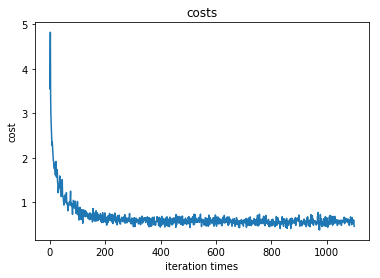

--------------------
train accuracy: 0.842522867475
test accuracy: 0.812524309607
Wall time: 1min 25s


In [25]:
costs = myNN.miniBatchRandom(learningRate=0.5,batchSize=256,batchTimes=100,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.2,batchSize=256,batchTimes=100,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.1,batchSize=256,batchTimes=100,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.05,batchSize=256,batchTimes=100,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.001,batchSize=256,batchTimes=200,getCost=True)
costs = costs + myNN.miniBatchRandom(learningRate=0.0001,batchSize=256,batchTimes=500,getCost=True)
# costs = costs + myNN.miniBatchRandom(learningRate=0.0000001,batchSize=128,batchTimes=300,getCost=True)

# 绘制cost函数曲线

plt.plot(costs)
plt.title('costs')
plt.xlabel("iteration times")
plt.ylabel("cost")
plt.show()

# 在预测时候，将输入的dropout删除
if "dropout-input" in myNN.hyperParameters: 
    print('delete dropout in input')
    myNN.hyperParameters.pop('dropout-input')
else:
    pass

print('-'*20)
print('train accuracy:',myNN.function['accuracyFunction'](myNN.predict(X = trainX),trainY))
print('test accuracy:',myNN.function['accuracyFunction'](myNN.predict(X = testX),testY))

## 测试自己画的图片

会打开自己本地画的一张名为“number.bmp”的图片

然后用训练好的神经网络来看看这个图片应该被归类到哪个数字

[[ True False False False False False False False False False False False
  False False False False False False False False False False False False
  False False]]
predict is: a


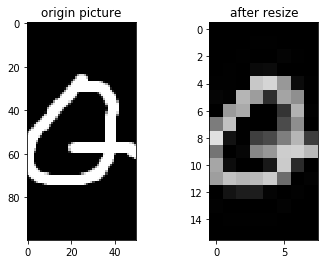

In [18]:
myImage = Image.open('test.bmp') # 打开图片
plt.subplot(121)
plt.imshow(myImage) # 显示图片
plt.title('origin picture')

plt.subplot(122)
myImage = myImage.resize((8,16),Image.ANTIALIAS) # 重置大小, 宽度为8, 高度为16
plt.imshow(myImage) # 显示图片
plt.title('after resize')


myImageArr = np.array(myImage) # 从图片获取 array
# print(myImageArr) # 输出array, 测试是否正确
testIm = np.sum(myImageArr,axis = 2) # RGB 值相加
# print('testIm',testIm)
testIm128 = (testIm > 100).astype(np.float16).reshape(128,1) # 重置array为训练数据的size
letterPre = myNN.predict(X = testIm128)
print(letterPre.T)
for i in range(26):
    if letterPre[i,0]:
        print("predict is: " + str(chr(ord('a')+i)))
plt.show()

## 结果分析

训练结果并不是很理想, 正确率不是很高, 有待开展进一步的工作

### hyperparameters分析

输入层为128

隐层从第1层到最后1层分别为

输出层为26

L2正则化中的lambda系数为0.001

无dropout

### 训练集分析与测试集分析

训练集上的正确率为`0.842522867475`

测试集上的正确率为`0.812524309607`

不得不说, 这个结果让人不是很满意

首先, 训练集没有达到很好的拟合, 因为正确率只有84%左右, 方差比较大

然后测试集的争取率与训练集相差了3个百分点, 说明偏差比较大